# GRU with uncertainty tutorial

In this tutorial, we show how to quickly set up and train an RNN regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_table

from deep4cast.forecasters import Forecaster
import deep4cast.metrics as metrics

%matplotlib inline

Using TensorFlow backend.


## Data preparation for single multivariate time series

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it. The data is prepared such that the forecaster view the data as a single example of a 26-dimensional time series. In another example, further down, we will train a forecaster that understands the data as 26 examples for univariate time series.

Text(0,0.5,'Quantity')

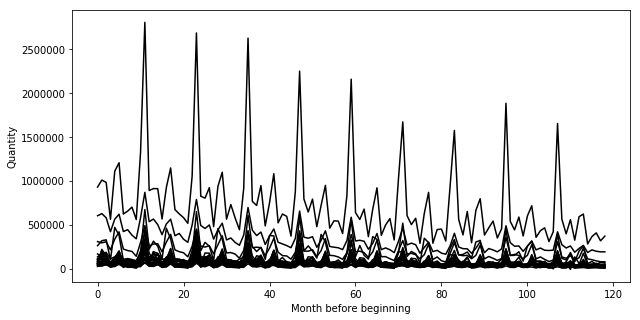

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df.values
data = np.expand_dims(data, 0)

# We just need a small holdout dataset for evaluation purposes
holdout = 9
train_data = data[:,:-9,:]
test_data = data[:,-9:,:]

# Plot the dataset
plt.figure(figsize=(10,5))
plt.plot(data[0,::-1,:], 'k')
plt.xlabel('Month before beginning')
plt.ylabel('Quantity')

## Recurrent Neural Network Forecaster using GRU cells

Now that we have cleaned and prepared our dataset, we can proceed to fit a regression model. Here, we choose the LSTM-GRU, with windowed training intput.

In [5]:
topology = [
    {
        'meta': {
            'layer_type': 'GRU', 
            'layer_id': 'gru1', 
            'parent_ids': ['input']
        },
        'params': {
            'units': 32, 
            'activation': 'relu',
            'return_sequences': False
        }
    }
]

Now, we can set up the forecaster object using arguments to specify lookbacks and forecasting horizons, as well as optimizer parameters. The default loss of the forecaster is the mean-squared error loss.

In [16]:
forecaster = Forecaster(
    topology,
    lookback=20,  # This is the number of time steps used to predict the future for each data point
    horizon=9,  # This is how many time steps into the future we want to produce
    optimizer='rmsprop',  # Which optimizer the forecaster is using
    loss='heteroscedastic_gaussian',  # This specifies a custom log-likelihood loss
    lr=0.001,  # This is the learning rate for the optimizer
    dropout_rate=0.1,  # The dropout rate refers to the MC dropout rate applied after each layer
    seed=3,  # Let's fix the seed for reproducability purposes
    max_epochs=10000  # Maximum number of epochs that the optimizer will perform
)

We can now fit the forecaster and unspect the training and validation losses. The plot below show the training and validation loss for each epoch of training. By default, the forecaster uses Keras' early stopping callback to stopp training when the validation set error increases. The default holdout from the input data used for validation is 10% of the data.

In [17]:
forecaster.fit(train_data, patience=50)  # patience is the number of epochs to wait until early stopping is executed

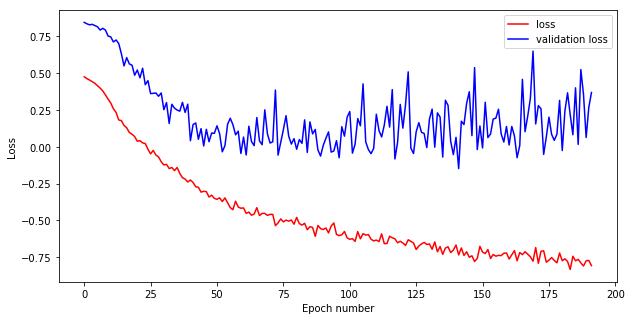

In [18]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

Using the trained model, we can make predictions for our dataset. The horizon parameter of the forecaster will determine how far into the future our predictions will reach. The forecast predictions are produced such that the forecasted values are extending the input time series. For example, if we use the training data here as input, the forecaster predictions will be made for time steps after the training data time steps.

In [22]:
predictions = forecaster.predict(data=train_data, n_samples=100)  # Draw 100 samples for predictions

Let's get the test set accuracy for different metrics from model

In [23]:
print('MSE: {}'.format(round(metrics.mse(test_data, predictions['mean']), 2)))
print('MAPE: {}%'.format(round(metrics.mape(test_data, predictions['mean']), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(test_data, predictions['mean']), 2)))

MSE: 1373871299.56
MAPE: 18.11%
SMAPE: 17.44%


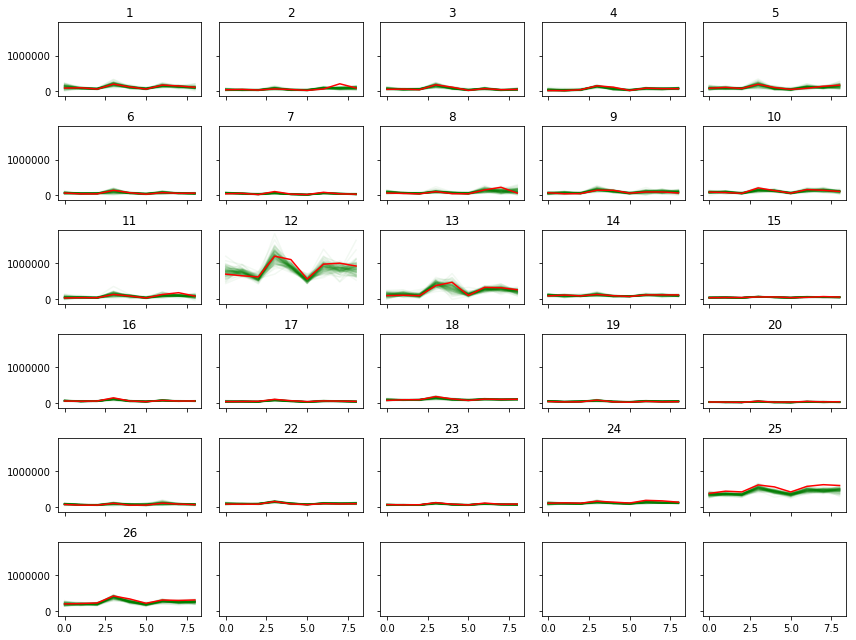

In [24]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, title in zip(axes.flat, 
                             test_data[0,:,:].T,
                             predictions['samples'].T,
                             range(1,26+1)):
    for ys in yp.T:
        ax.plot(ys[0,:], 'g-', alpha=0.05)
    ax.plot(ya, 'r-')
    ax.set_title(title)

plt.tight_layout()

## Data preparation for multiple univariate time series

Now we will train a forecaster that understands the data as 26 examples for univariate time series. This fact is illustrated in the figure below by coloring each time series differently.

Text(0,0.5,'Quantity')

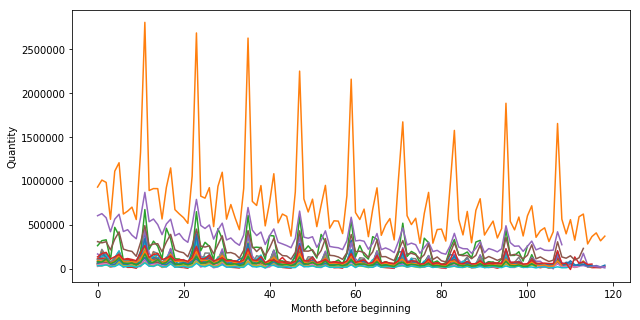

In [25]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df.values.T
data = np.expand_dims(data, -1)

# Let's make the algorithms life harder by randomly cutting of up to the first 20 data points
new_data = []
for time_series in data:
    cutoff = np.random.randint(20)
    new_data.append(time_series[cutoff:,:])
data = np.array(new_data)

# We just need a small holdout dataset for evaluation purposes
holdout = 9
train_data, test_data = [], []
for time_series in data:
    train_data.append(time_series[:-9,:])
    test_data.append(time_series[-9:,:])
train_data = np.array(train_data)
test_data = np.array(test_data)
    
# Plot the dataset
plt.figure(figsize=(10,5))
for time_series in data:
    plt.plot(time_series[::-1])
plt.xlabel('Month before beginning')
plt.ylabel('Quantity')

For reasons of comparibility, we use the same forecaster architecture as above.

In [26]:
forecaster = Forecaster(
    topology,
    lookback=20,  # This is the number of time steps used to predict the future for each data point
    horizon=9,  # This is how many time steps into the future we want to produce
    optimizer='rmsprop',  # Which optimizer the forecaster is using
    loss='heteroscedastic_gaussian',  # This specifies a custom log-likelihood loss
    lr=0.001,  # This is the learning rate for the optimizer
    dropout_rate=0.1,  # The dropout rate refers to the MC dropout rate applied after each layer
    seed=3,  # Let's fix the seed for reproducability purposes
    max_epochs=10000  # Maximum number of epochs that the optimizer will perform
)

In [27]:
forecaster.fit(train_data, patience=50)  # patience referes to the number of epochs to wait until early stopping

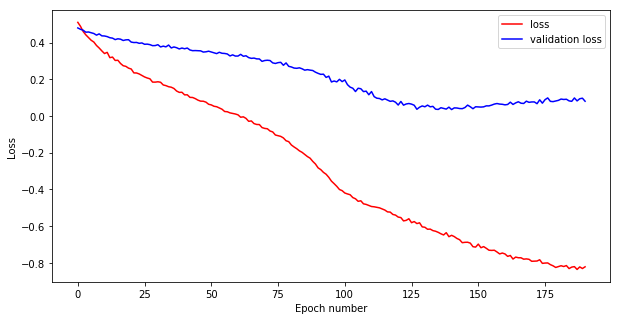

In [28]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

Again, we can generate predictions see what we get :).

In [29]:
predictions = forecaster.predict(data=train_data, n_samples=100)  # Just as before, we produce predictions

In [30]:
print('MSE: {}'.format(round(metrics.mse(test_data, predictions['mean']), 2)))
print('MAPE: {}%'.format(round(metrics.mape(test_data, predictions['mean']), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(test_data, predictions['mean']), 2)))

MSE: 35154066765.94
MAPE: 79.13%
SMAPE: 77.76%


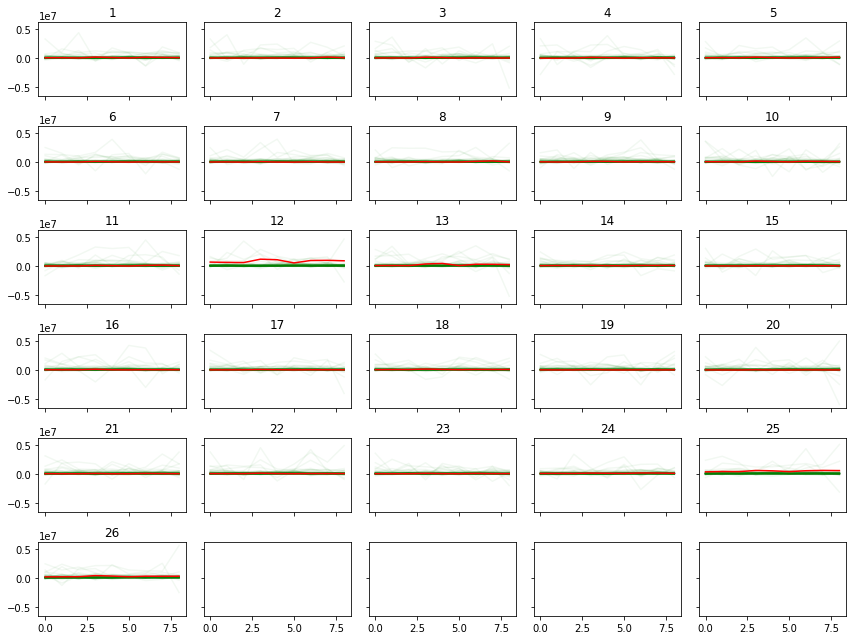

In [31]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, title in zip(axes.flat, 
                             test_data[:,:,0],
                             np.swapaxes(predictions['samples'][:,:,:,0],0,1),
                             range(1,26+1)):
    for ys in yp:
        ax.plot(ys, 'g-', alpha=0.05)
    ax.plot(ya, 'r-')
    ax.set_title(title)

plt.tight_layout()